# Imports

In [40]:
import torch
import torchvision
import numpy as np
from torchvision import transforms
import time
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

# Dataset

In [20]:
class FashionMNIST:
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.root = "/"
        self.batch_size = batch_size
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels."""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train)
    
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        plt.figure(figsize=(2 * ncols, 2 * nrows))
        max_imgs = min(X.shape[0], nrows * ncols)
        for i in range(max_imgs):
            plt.subplot(nrows, ncols, i + 1)
            img = X[i].squeeze().numpy()
            plt.imshow(img, cmap='gray')
            plt.title(labels[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [21]:
data = FashionMNIST(resize=(32, 32))  
len(data.train), len(data.val)

(60000, 10000)

In [10]:
data.train[0][0].shape

torch.Size([1, 32, 32])

In [11]:
X, y = next(iter(data.get_dataloader(train=True)))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [30]:
tic = time.time()
for X, y in data.get_dataloader(train=True):
    continue
f'{time.time() - tic:.2f} sec'

'6.06 sec'

## Visualization

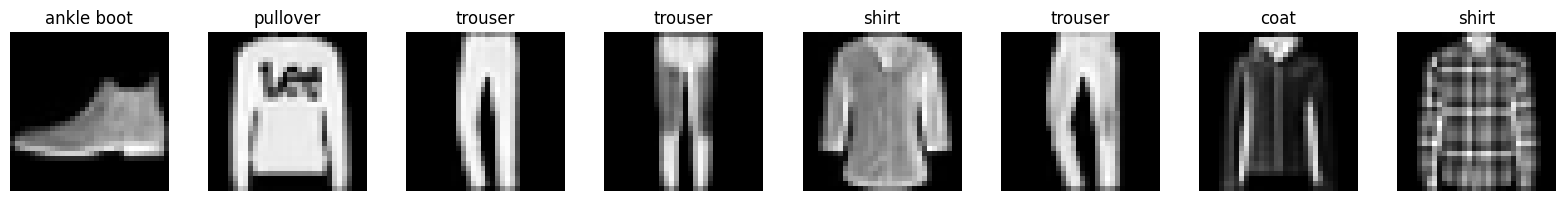

In [22]:
batch = next(iter(data.get_dataloader(train=False)))
data.visualize(batch)

# Classification Model (Neural Network)

## Implementation from Scratch

In [23]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition 

In [25]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [28]:
class SoftmaxRegression:
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.lr = lr
        self.sigma = sigma
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)
    
    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)
    
    def train(self, x_train, y_train, epochs, learning_rate):
        for epoch in range(epochs):
            y_pred = self.forward(x_train)
            loss = self.loss(y_pred, y_train)
            loss.backward()
            with torch.no_grad():
                self.W -= learning_rate * self.W.grad
                self.b -= learning_rate * self.b.grad
                self.W.grad.zero_()
                self.b.grad.zero_()

In [33]:
training_data = data.get_dataloader(train=True)
print(training_data)

In [ ]:
model = SoftmaxRegression(num_inputs=32*32, num_outputs=10, lr=0.1)
for X_train, y_train in training_data:
    model.train(X_train, y_train, epochs=1, learning_rate=0.01)

In [37]:
X, y = next(iter(data.get_dataloader(train=False)))
preds = model.forward(X).argmax(axis=1)
preds.shape

torch.Size([64])

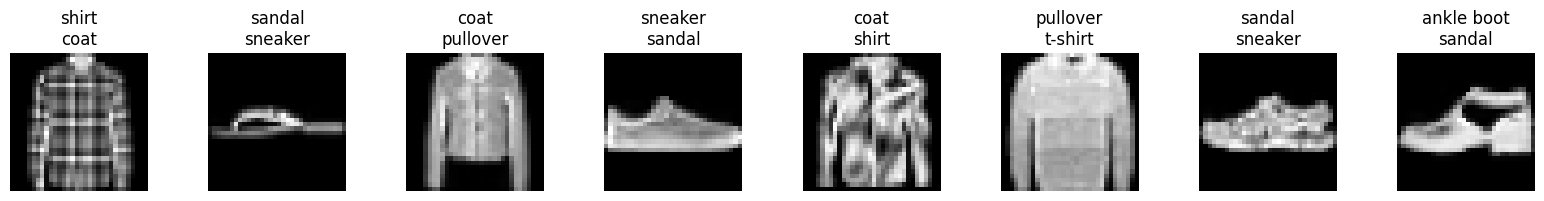

In [38]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

## More Concise Implementation

In [51]:
class SoftmaxRegression:
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        self.num_outputs = num_outputs
        self.lr = lr
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def parameters(self):
        return [self.W, self.b]
    
    def forward(self, X):
        return self.net(X)
    
    def loss(self, y_hat, y, averaged=True):
        y_hat = y_hat.reshape((-1, y_hat.shape[-1]))
        y = y.reshape((-1,))
        return F.cross_entropy(
            y_hat, y, reduction='mean' if averaged else 'none')
        
    def train(self, x_train, y_train, epochs, learning_rate):
        optimizer = torch.optim.SGD(self.net.parameters(), lr=learning_rate)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x_train)
            loss = self.loss(y_pred, y_train)
            loss.backward()
            optimizer.step()


In [43]:
training_data = data.get_dataloader(train=True)

In [52]:
model = SoftmaxRegression(num_inputs=32*32, num_outputs=10, lr=0.1)
for X_train, y_train in training_data:
    model.train(X_train, y_train, epochs=1, learning_rate=0.01)

In [53]:
X, y = next(iter(data.get_dataloader(train=False)))
preds = model.forward(X).argmax(axis=1)
preds.shape

torch.Size([64])

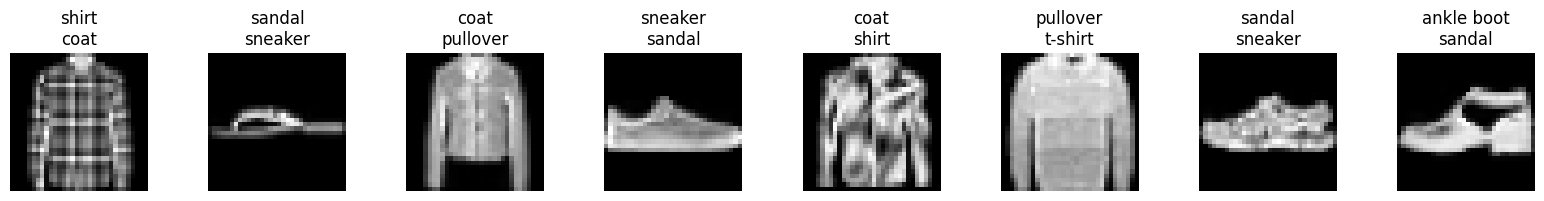

In [54]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)